<a href="https://www.nvidia.com/dli"> <img src="../images/DLI_Header.png" alt="Header" style="width: 400px;"/> </a>

# 3.0 Build a 3-Class Text Classifier

In this notebook, you'll build an application to classify medical disease abstracts into one of three categories: cancer diseases, neurological diseases and disorders, and "other" for anything else.

As presented in the [1.0 Explore the Data](010_ExploreData.ipynb) notebook, the data for the project includes training and evaluation sets already labeled, and a test set with no labels, which will need to be fixed. You'll follow the steps outlined in the [2.0 NLP Projects with NeMo](020_ExploreNeMo.ipynb) to build your application, train it, and test it.

**[3.1 Set Up the Project](#3.1-Set-Up-the-Project)**<br>
&nbsp;&nbsp;&nbsp;&nbsp;[3.1.1 Input Parameters](#3.1.1-Input-Parameters)<br>
&nbsp;&nbsp;&nbsp;&nbsp;[3.1.2 Prepare the Input Data](#3.1.2-Prepare-the-Input-Data)<br>
**[3.2 Exercise: Create Neural Modules](#3.2-Exercise:-Create-Neural-Modules)**<br>
**[3.3 Create Neural Graphs](#3.3-Create-Neural-Graphs)**<br>
&nbsp;&nbsp;&nbsp;&nbsp;[3.3.1 Training Graph](#3.3.1-Training-Graph)<br>
&nbsp;&nbsp;&nbsp;&nbsp;[3.3.2 Exercise: Create the Validation Graph](#3.3.2-Exercise:-Create-the-Validation-Graph)<br>
&nbsp;&nbsp;&nbsp;&nbsp;[3.3.3 Visualize Embeddings Before Training](#3.3.3-Visualize-Embeddings-Before-Training)<br>
**[3.4 Training](#3.4-Training)**<br>
&nbsp;&nbsp;&nbsp;&nbsp;[3.4.1 Set the Learning Rate and Optimizer](#3.4.1-Set-the-Learning-Rate-and-Optimizer)<br>
&nbsp;&nbsp;&nbsp;&nbsp;[3.4.2 Create the Callbacks](#3.4.2-Create-the-Callbacks)<br>
&nbsp;&nbsp;&nbsp;&nbsp;[3.4.3 Run the Trainer](#3.4.3-Run-the-Trainer)<br>
&nbsp;&nbsp;&nbsp;&nbsp;[3.4.4 Visualize Embeddings After Training](#3.4.4-Visualize-Embeddings-After-Training)<br>
**[3.5 Inference](#3.5-Inference)**<br>
&nbsp;&nbsp;&nbsp;&nbsp;[3.5.1 Exercise: Create the Test Graph](#3.5.1-Exercise:-Create-the-Test-Graph)<br>
&nbsp;&nbsp;&nbsp;&nbsp;[3.5.2 Run Inference on the Test Set](#3.5.2-Run-Inference-on-the-Test-Set)<br>
&nbsp;&nbsp;&nbsp;&nbsp;[3.5.3 Inference Results](#3.5.3-Inference-Results)<br>
&nbsp;&nbsp;&nbsp;&nbsp;[3.5.4 Single Sentence Classification](#3.5.4-Single-Sentence-Classification)<br>
**[3.6 Exercise: Change the Language Model](#3.6-Exercise:-Change-the-Language-Model)**<br>

# 3.1 Set Up the Project

You've learned the general paradigm for creating NLP tasks with NVIDIA NeMo.  Start by importing all the specific libraries, objects, and functions you'll need for text classification using a pre-trained language model.

<img src="../images/nemo/nm-pipe.png" width=800>

In [1]:
# Import useful math and utility libraries
import os
import json
import math
import numpy as np
import pandas as pd
pd.options.display.max_colwidth = -1
import torch
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

# Import the nemo toolkit and NLP libraries
import nemo
import nemo.collections.nlp as nemo_nlp

# Import the specific neural modules we need
from nemo.collections.nlp.nm.data_layers import BertTextClassificationDataLayer
from nemo.collections.nlp.nm.trainables import get_pretrained_lm_model, SequenceClassifier
from nemo.backends.pytorch.common.losses import CrossEntropyLossNM
    
# Import helpers for fetching the learning rate and tokenizer functions
from nemo.utils.lr_policies import get_lr_policy
from nemo.collections.nlp.data.tokenizers import get_tokenizer

# Import callbacks and callback functions
from nemo.core import SimpleLogger, TensorboardLogger, EvaluatorCallback, CheckpointCallback
from nemo.collections.nlp.callbacks.text_classification_callback import eval_iter_callback, eval_epochs_done_callback

%matplotlib inline

[NeMo W 2020-07-21 15:59:54 audio_preprocessing:56] Could not import torchaudio. Some features might not work.


## 3.1.1 Input Parameters
For reusability and convenience, set up all of the parameters in one place at the beginning of the notebook.  This way, it will be easy to make changes when you want to try alternate models and configurations. 

### Model Choice
There are lots of models to choose from. Recall that the pretrained language models we are starting from were trained in a self-supervised manner over general text.  The models vary in size, and thus in memory and processing requirements. In addition, some were trained on "uncased" data, where all capital letters have been changed to lower case.  This results in a smaller vocabulary file, and is generally fine for many tasks, but may not be best for tasks where casing matters, such as NER.  These are some of the tradeoffs you should consider in choosing your model.  The table below gives statistics for a few of the NeMo pretrained models:

| Model Name                 | Pretraining                                              | Size            |
|----------------------------|----------------------------------------------------------|-----------------|
| bert-base-uncased          | uncased Wikipedia and BookCorpus                         | 110M parameters |
| bert-base-cased            | cased Wikipedia and BookCorpus                           | 110M parameters |
| bert-large-uncased         | uncased Wikipedia and BookCorpus                         | 335M parameters |
| bert-large-cased           | cased Wikipedia and BookCorpus                           | 335M parameters |
| megatron-bert-345m-uncased | uncased Wikipedia, RealNews, OpenWebText, and CC-Stories | 335M parameters |
| megatron-bert-345m-cased   | cased Wikipedia, RealNews, OpenWebText, and CC-Stories   | 335M parameters |

For more discussion on pretrained models and their parameters, please see the blog post, ["State-of-the-Art Language Modeling Using Megatron on the NVIDIA A100 GPU"](https://developer.nvidia.com/blog/language-modeling-using-megatron-a100-gpu/).<br>
The [AMP_OPTIMIZATION_LEVEL](https://nvidia.github.io/apex/amp.html#opt-levels) parameter can be used to set the mixed precision level.

In [2]:
# Identify the input data location.
DATA_DIR = '/dli/task/data/NCBI_tc-3/'

# Identify the pretrained model and where information and checkpoints will be logged
PRETRAINED_MODEL_NAME = 'bert-base-uncased'
WORK_DIR = '/dli/task/data/logs-tc-bbu/'

# PRETRAINED_MODEL_NAME = 'megatron-bert-345m-uncased'
# WORK_DIR = '/dli/task/data/logs-tc-m345u/'

# PRETRAINED_MODEL_NAME = 'bert-large-uncased'
# WORK_DIR = '/dli/task/data/logs-tc-blu/'

# To use mixed precision, set AMP_OPTIMIZATION_LEVEL to 'O1' or 'O2',
# to train without mixed precision, set it to 'O0'.
AMP_OPTIMIZATION_LEVEL = 'O1'

# Set the number of words in the sequences
# Shorter sequences will be padded with 0s, longer ones truncated
MAX_SEQ_LEN = 128 
# set batch size - will need smaller 16 for 'bert-large-uncased' and 'megatron-bert-345m-uncased'
BATCH_SIZE = 64

## 3.1.2 Prepare the Input Data
In order to take advantage of NeMo's pre-built sentence classification data layer, the data should be formatted as "sentence\tlabel" (sentence tab label).

The training and evaluation datasets already have the correct "sentence\tlabel" format and are ready to go for training, but the test set has no labels and needs to be updated. 

In [3]:
!ls -lh $DATA_DIR

total 1.4M
-rw-r--r-- 1 root root 133K Jul 21 15:59 dev.tsv
-rw-r--r-- 1 root root  15K Jul 21 15:59 test.tsv
-rw-r--r-- 1 root root 1.2M Jul 21 15:59 train.tsv


In [4]:
test_df = pd.read_csv(DATA_DIR + 'test.tsv', sep='\t')
test_df.head(2)

,sentence
0,"Clustering of missense mutations in the ataxia-telangiectasia gene in a sporadic T-cell leukaemia. Ataxia-telangiectasia ( A-T ) is a recessive multi-system disorder caused by mutations in the ATM gene at 11q22-q23 ( ref . 3 ) . The risk of cancer , especially lymphoid neoplasias , is substantially elevated in A-T patients and has long been associated with chromosomal instability . By analysing tumour DNA from patients with sporadic T-cell prolymphocytic leukaemia ( T-PLL ) , a rare clonal malignancy with similarities to a mature T-cell leukaemia seen in A-T , we demonstrate a high frequency of ATM mutations in T-PLL . In marked contrast to the ATM mutation pattern in A-T , the most frequent nucleotide changes in this leukaemia were missense mutations . These clustered in the region corresponding to the kinase domain , which is highly conserved in ATM-related proteins in mouse , yeast and Drosophila . The resulting amino-acid substitutions are predicted to interfere with ATP binding or substrate recognition . Two of seventeen mutated T-PLL samples had a previously reported A-T allele . In contrast , no mutations were detected in the p53 gene , suggesting that this tumour suppressor is not frequently altered in this leukaemia . Occasional missense mutations in ATM were also found in tumour DNA from patients with B-cell non-Hodgkins lymphomas ( B-NHL ) and a B-NHL cell line . The evidence of a significant proportion of loss-of-function mutations and a complete absence of the normal copy of ATM in the majority of mutated tumours establishes somatic inactivation of this gene in the pathogenesis of sporadic T-PLL and suggests that ATM acts as a tumour suppressor . As constitutional DNA was not available , a putative hereditary predisposition to T-PLL will require further investigation . ."
1,"Myotonic dystrophy protein kinase is involved in the modulation of the Ca2+ homeostasis in skeletal muscle cells. Myotonic dystrophy ( DM ) , the most prevalent muscular disorder in adults , is caused by ( CTG ) n-repeat expansion in a gene encoding a protein kinase ( DM protein kinase ; DMPK ) and involves changes in cytoarchitecture and ion homeostasis . To obtain clues to the normal biological role of DMPK in cellular ion homeostasis , we have compared the resting [ Ca2 + ] i , the amplitude and shape of depolarization-induced Ca2 + transients , and the content of ATP-driven ion pumps in cultured skeletal muscle cells of wild-type and DMPK [ - / - ] knockout mice . In vitro-differentiated DMPK [ - / - ] myotubes exhibit a higher resting [ Ca2 + ] i than do wild-type myotubes because of an altered open probability of voltage-dependent l-type Ca2 + and Na + channels . The mutant myotubes exhibit smaller and slower Ca2 + responses upon triggering by acetylcholine or high external K + . In addition , we observed that these Ca2 + transients partially result from an influx of extracellular Ca2 + through the l-type Ca2 + channel . Neither the content nor the activity of Na + / K + ATPase and sarcoplasmic reticulum Ca2 + -ATPase are affected by DMPK absence . In conclusion , our data suggest that DMPK is involved in modulating the initial events of excitation-contraction coupling in skeletal muscle . ."


In [5]:
# Add a label column filled with the '0' value, which will be ignored during testing.
test_df['label'] = 0
test_df = test_df[['sentence', 'label']]

Now we should see the headings we need: "sentence" and "label".

In [6]:
test_df.head()

,sentence,label
0,"Clustering of missense mutations in the ataxia-telangiectasia gene in a sporadic T-cell leukaemia. Ataxia-telangiectasia ( A-T ) is a recessive multi-system disorder caused by mutations in the ATM gene at 11q22-q23 ( ref . 3 ) . The risk of cancer , especially lymphoid neoplasias , is substantially elevated in A-T patients and has long been associated with chromosomal instability . By analysing tumour DNA from patients with sporadic T-cell prolymphocytic leukaemia ( T-PLL ) , a rare clonal malignancy with similarities to a mature T-cell leukaemia seen in A-T , we demonstrate a high frequency of ATM mutations in T-PLL . In marked contrast to the ATM mutation pattern in A-T , the most frequent nucleotide changes in this leukaemia were missense mutations . These clustered in the region corresponding to the kinase domain , which is highly conserved in ATM-related proteins in mouse , yeast and Drosophila . The resulting amino-acid substitutions are predicted to interfere with ATP binding or substrate recognition . Two of seventeen mutated T-PLL samples had a previously reported A-T allele . In contrast , no mutations were detected in the p53 gene , suggesting that this tumour suppressor is not frequently altered in this leukaemia . Occasional missense mutations in ATM were also found in tumour DNA from patients with B-cell non-Hodgkins lymphomas ( B-NHL ) and a B-NHL cell line . The evidence of a significant proportion of loss-of-function mutations and a complete absence of the normal copy of ATM in the majority of mutated tumours establishes somatic inactivation of this gene in the pathogenesis of sporadic T-PLL and suggests that ATM acts as a tumour suppressor . As constitutional DNA was not available , a putative hereditary predisposition to T-PLL will require further investigation . .",0
1,"Myotonic dystrophy protein kinase is involved in the modulation of the Ca2+ homeostasis in skeletal muscle cells. Myotonic dystrophy ( DM ) , the most prevalent muscular disorder in adults , is caused by ( CTG ) n-repeat expansion in a gene encoding a protein kinase ( DM protein kinase ; DMPK ) and involves changes in cytoarchitecture and ion homeostasis . To obtain clues to the normal biological role of DMPK in cellular ion homeostasis , we have compared the resting [ Ca2 + ] i , the amplitude and shape of depolarization-induced Ca2 + transients , and the content of ATP-driven ion pumps in cultured skeletal muscle cells of wild-type and DMPK [ - / - ] knockout mice . In vitro-differentiated DMPK [ - / - ] myotubes exhibit a higher resting [ Ca2 + ] i than do wild-type myotubes because of an altered open probability of voltage-dependent l-type Ca2 + and Na + channels . The mutant myotubes exhibit smaller and slower Ca2 + responses upon triggering by acetylcholine or high external K + . In addition , we observed that these Ca2 + transients partially result from an influx of extracellular Ca2 + through the l-type Ca2 + channel . Neither the content nor the activity of Na + / K + ATPase and sarcoplasmic reticulum Ca2 + -ATPase are affected by DMPK absence . In conclusion , our data suggest that DMPK is involved in modulating the initial events of excitation-contraction coupling in skeletal muscle . .",0
2,"Constitutional RB1-gene mutations in patients with isolated unilateral retinoblastoma. In most patients with isolated unilateral retinoblastoma , tumor development is initiated by somatic inactivation of both alleles of the RB1 gene . However , some of these patients can transmit retinoblastoma predisposition to their offspring . To determine the frequency and nature of constitutional RB1-gene mutations in patients with isolated unilateral retinoblastoma , we analyzed DNA from peripheral blood and from tumor tissue . The analysis of tumors from 54 ( 71 % ) of 76 informative patients showed loss of constitutional heterozygosity ( LOH ) at intragenic loci . Three of 13 uninformative patients had constitutional deletions . For

In [7]:
# Save the updated test file to disk
test_df.to_csv(os.path.join(DATA_DIR, 'labeled_test.tsv'), sep='\t', index=False)
!ls -lh $DATA_DIR

total 1.4M
-rw-r--r-- 1 root root 133K Jul 21 15:59 dev.tsv
-rw-r--r-- 1 root root  16K Jul 21 15:59 labeled_test.tsv
-rw-r--r-- 1 root root  15K Jul 21 15:59 test.tsv
-rw-r--r-- 1 root root 1.2M Jul 21 15:59 train.tsv


# 3.2 Exercise: Create Neural Modules
You have everything you need to do most of this part yourself.  You're going to create the necessary neural modules for three pipelines:  training, validation, and test.  We always must begin by instantiating the `NerualModuleFactory`.

In [8]:
# Instantiate the neural module factory
nf = nemo.core.NeuralModuleFactory(log_dir=WORK_DIR,
                                   create_tb_writer=True,
                                   add_time_to_log_dir=False,
                                   optimization_level=AMP_OPTIMIZATION_LEVEL)

Training, validation, and test each need a data layer neural module instantiated with `BertTextClassificationDataLayer`.  They will reuse the same language and classifier neural modules.  Only the training and validation pipelines will need a loss function neural module, which will be reused as well.

In the next cell, the tokenizer and training data layer neural module are instantiated to get you started.  The tokenizer is required for the data layers.

In [9]:
# Instantiate the data Layer neural module for training.
#     Include the input file locations, tokenizer, max_seq_length, and batch size.
#     Set the shuffle and use_cache to True for training  
USE_CACHE = True
tokenizer = get_tokenizer(tokenizer_name='nemobert', pretrained_model_name=PRETRAINED_MODEL_NAME)
dl_train = BertTextClassificationDataLayer(input_file=os.path.join(DATA_DIR, 'train.tsv'),
                                             tokenizer=tokenizer,
                                             max_seq_length=MAX_SEQ_LEN,
                                             shuffle=True,
                                             batch_size=BATCH_SIZE,
                                             use_cache=USE_CACHE)

[NeMo I 2020-07-21 15:59:59 bert_tokenizer:78] Deriving bert model type from pretrained model name.



[NeMo I 2020-07-21 16:00:01 text_classification_dataset:82] /dli/task/data/NCBI_tc-3/train.tsv: 962
[NeMo I 2020-07-21 16:00:16 data_preprocessing:250] Min: 74 |                  Max: 733 |                  Mean: 300.6756756756757 |                  Median: 299.5
[NeMo I 2020-07-21 16:00:16 data_preprocessing:252] 75 percentile: 364.0
[NeMo I 2020-07-21 16:00:16 data_preprocessing:253] 99 percentile: 570.9699999999997
[NeMo I 2020-07-21 16:00:17 text_classification_dataset:118] 937 out of 962                         sentences with more than 128 subtokens.
[NeMo I 2020-07-21 16:00:17 text_classification_dataset:175] *** Example ***
[NeMo I 2020-07-21 16:00:17 text_classification_dataset:176] example_index: 0
[NeMo I 2020-07-21 16:00:17 text_classification_dataset:177] subtokens: [CLS] ##16 and cd ##k ##4 genes have been reported in a subset of mel ##ano ##ma pe ##di ##gree ##s , but their prevalence is not well known . we searched for such ge ##rm ##line mutations in 48 french mel ##an

In the next five cells, instantiate:
1. Validation data layer neural module
1. Test data layer neural module
1. Language model neural module
1. Text classification model neural module
1. Loss neural module

Look for and fix the <i><strong><span style="color:green;">#FIXME</span><strong></i> code lines.  If you get stuck, look back at the [2.0 NLP Projects with NeMo](020_ExploreNeMo.ipynb) notebook for inspiration or the [solution notebook](solution_notebooks/SOLN_030_TextClassification.ipynb) for the answer.

In [10]:
# 1. Instantiate the data Layer neural module for validation.
#     Include the input file locations, tokenizer, max_seq_length, and batch size.
#     Set the shuffle to False (the default value) and use_cache to True for validation  
dl_val = BertTextClassificationDataLayer(input_file=os.path.join(DATA_DIR, 'dev.tsv'),
                                             tokenizer=tokenizer,
                                             max_seq_length=MAX_SEQ_LEN,
                                             batch_size=BATCH_SIZE,
                                             use_cache=USE_CACHE)

[NeMo I 2020-07-21 16:00:17 text_classification_dataset:82] /dli/task/data/NCBI_tc-3/dev.tsv: 100
[NeMo I 2020-07-21 16:00:19 data_preprocessing:250] Min: 120 |                  Max: 506 |                  Mean: 307.0 |                  Median: 301.5
[NeMo I 2020-07-21 16:00:19 data_preprocessing:252] 75 percentile: 363.0
[NeMo I 2020-07-21 16:00:19 data_preprocessing:253] 99 percentile: 503.03
[NeMo I 2020-07-21 16:00:19 text_classification_dataset:118] 99 out of 100                         sentences with more than 128 subtokens.
[NeMo I 2020-07-21 16:00:19 text_classification_dataset:175] *** Example ***
[NeMo I 2020-07-21 16:00:19 text_classification_dataset:176] example_index: 0
[NeMo I 2020-07-21 16:00:19 text_classification_dataset:177] subtokens: [CLS] remained elusive . we now show that br ##ca ##1 en ##codes a 190 - k ##d protein with sequence homo ##logy and bio ##chemical analogy to the gran ##in protein family . interesting ##ly , br ##ca ##2 also includes a motif similar t

In [11]:
# 2. Instantiate the data Layer neural module for testing (inference).
#     Include the input file locations, tokenizer, max_seq_length, and batch size.
#     Set the shuffle to False (the default value) and use_cache to False (the default value) for testing  
dl_test = BertTextClassificationDataLayer(input_file=os.path.join(DATA_DIR, 'labeled_test.tsv'),
                                             tokenizer=tokenizer,
                                             max_seq_length=MAX_SEQ_LEN,
                                             batch_size=BATCH_SIZE)

[NeMo I 2020-07-21 16:00:19 text_classification_dataset:82] /dli/task/data/NCBI_tc-3/labeled_test.tsv: 10
[NeMo I 2020-07-21 16:00:19 data_preprocessing:250] Min: 194 |                  Max: 488 |                  Mean: 347.6 |                  Median: 344.0
[NeMo I 2020-07-21 16:00:19 data_preprocessing:252] 75 percentile: 418.5
[NeMo I 2020-07-21 16:00:19 data_preprocessing:253] 99 percentile: 484.58
[NeMo I 2020-07-21 16:00:19 text_classification_dataset:118] 10 out of 10                         sentences with more than 128 subtokens.
[NeMo I 2020-07-21 16:00:19 text_classification_dataset:175] *** Example ***
[NeMo I 2020-07-21 16:00:19 text_classification_dataset:176] example_index: 0
[NeMo I 2020-07-21 16:00:19 text_classification_dataset:177] subtokens: [CLS] atm were also found in tu ##mour dna from patients with b - cell non - ho ##d ##g ##kins l ##ym ##ph ##oma ##s ( b - nhl ) and a b - nhl cell line . the evidence of a significant proportion of loss - of - function mutations

In [12]:
# 3. Instantiate the Language Model with the get_pretrained_lm_model function
#    Include the pretrained_model_name as the parameter
lm = get_pretrained_lm_model(pretrained_model_name=PRETRAINED_MODEL_NAME)

# Sanity check the number of weight parameters
#    It should be around 110M for `bert-base-uncased`
print(f'{PRETRAINED_MODEL_NAME} has {lm.num_weights} weights')


bert-base-uncased has 109482240 weights


In [13]:
# 4. Instantiate the SequenceClassifier
#    Include the hidden_size, num_classes (which is 3), num_layers (set to 2), 
#    and a dropout rate of 0.1
lm_hidden_size = lm.hidden_size
mlp = SequenceClassifier(hidden_size=lm.hidden_size, 
                         num_classes=3, 
                         num_layers=2, 
                         dropout=0.1)

# Compared to the language model, the MLP should be tiny (only 1/2 million).
print(f'MLP has {mlp.num_weights} weights')

MLP has 592899 weights


In [14]:
# 5. Instantiate the CrossEntropyLossNM Loss Function - no parameters required
loss = CrossEntropyLossNM()

Nice job!  Your neural modules are set up.

# 3.3 Create Neural Graphs
Define the neural graphs by linking the output of each neural module with the input of the next one in the pipeline.  If any of these fail, it may be because the neural module was not correctly instantiated in the previous exercise. These graphs define how data will flow through the neural modules. 

You will set up graphs for training and validation.  You'll set up the graph for testing (inference) after the network is trained.

## 3.3.1 Training Graph
<figure>
    <img src="../images/nemo/train_graph.png" width=800>
    <figcaption style="text-align:center;">Training Graph</figcaption>
</figure>

We'll use the outputs for each neural module to define the inputs of the next one in the pipeline. 

In [15]:
# Define the data output from the data layer
train_input, train_token_types, train_attn_mask, train_labels = dl_train()

# Define train_embeddings from the language model, based on inputs from the data layer  
train_embeddings = lm(input_ids=train_input,
                      token_type_ids=train_token_types,
                      attention_mask=train_attn_mask)

# Define the train_logits from the clasifier, based on the embeddings from the language model
train_logits = mlp(hidden_states=train_embeddings)

# Define the train_loss based on the classifier logits and data layer labels
train_loss = loss(logits=train_logits, labels=train_labels)

## 3.3.2 Exercise: Create the Validation Graph
The validation graph is very similar to the training graph and uses most of the same neural modules. Only the data layer module is different. 

<figure>
    <img src="../images/nemo/val_graph.png" width=800>
    <figcaption style="text-align:center;">Validation Graph</figcaption>
</figure>

In the cell below, look for and fix the <i><strong><span style="color:green;">#FIXME</span><strong></i> code lines (there are four of them).  If you get stuck, look back at the training graph you just set up for inspiration or the [solution notebook](solution_notebooks/SOLN_030_TextClassification.ipynb) for the answer.

In [16]:
# Define the data output from the data layer
val_input, val_token_types, val_attn_mask, val_labels = dl_val()

# Define val_embeddings from the language model, based on inputs from the data layer  
val_embeddings = lm(input_ids=val_input,
                      token_type_ids=val_token_types,
                      attention_mask=val_attn_mask)

# Define val_logits from the clasifier, based on the embeddings from the language model
val_logits = mlp(hidden_states=val_embeddings)

# Define val_loss based on the classifier logits and data layer labels
val_loss = loss(logits=val_logits, labels=val_labels)

Excellent!  You've set up the pipelines for training and validation.

## 3.3.3 Visualize Embeddings Before Training
Before running the trainer, lets get visual idea of how well the language model you've chosen distinguishes between classes without any training.  As a quick proxy, we'll choose just words that are representative of each of the three types of abstracts.  Since language model embeddings are 768 dimensional for BERT base and 1024 dimensional for BERT large, we can't really visualize them directly, so we'll first apply [t-Distributed Stochastic Neighbor Embedding (t-SNE)](https://towardsdatascience.com/an-introduction-to-t-sne-with-python-example-5a3a293108d1) and reduce the embeddings to two dimensions.

In [17]:
spectrum_words = ['cancer', 'lymphoma', 'melanoma', 'breast cancer', 'carcinoma',
                  'parkinson disease', 'neuropathy', 'muscular dystrophy', 'dystonia', 'hodgkin disease',
                  'bacterial infection', 'genetic disease', 'eczema', 'diabetes', 'deficiency',]

spectrum_file = os.path.join(DATA_DIR, 'cancer_neuro_other.tsv')
with open(spectrum_file, 'w+') as f:
    f.write('sentence\tlabel')
    for word in spectrum_words:
        f.write('\n' + word + '\t0')

In [18]:
spectrum_df = pd.read_csv(spectrum_file, delimiter='\t')
print(spectrum_df.head())

        sentence  label
0  cancer         0    
1  lymphoma       0    
2  melanoma       0    
3  breast cancer  0    
4  carcinoma      0    


Next, we'll create a data layer just for this mini-dataset of words, and a graph to match.  We won't need the classifier or loss neural modules for this graph, because we are not training or even classifying on the words.  We are just going to see the results of the words run through the language model, to see if they group together naturally by category.

<figure>
    <img src="../images/nemo/spectrum_graph.png" width=400>
    <figcaption style="text-align:center;">Spectrum Graph</figcaption>
</figure>

In [19]:
# Create a data layer neural module for the spectrum words
dl_spectrum = BertTextClassificationDataLayer(input_file=spectrum_file,
                                                tokenizer=tokenizer,
                                                max_seq_length=MAX_SEQ_LEN,
                                                batch_size=BATCH_SIZE)

# Define the graph connections for the spectrum inference graph
# There are only two neural modules in this graph: the data layer (dl_spectrum) and the language model already defined (lm)
spectrum_input, spectrum_token_types, spectrum_attn_mask, _ = dl_spectrum()
spectrum_embeddings = lm(input_ids=spectrum_input,
                           token_type_ids=spectrum_token_types,
                           attention_mask=spectrum_attn_mask)

[NeMo I 2020-07-21 16:00:34 text_classification_dataset:82] /dli/task/data/NCBI_tc-3/cancer_neuro_other.tsv: 15
[NeMo I 2020-07-21 16:00:34 data_preprocessing:250] Min: 3 |                  Max: 7 |                  Mean: 4.666666666666667 |                  Median: 5.0
[NeMo I 2020-07-21 16:00:34 data_preprocessing:252] 75 percentile: 5.0
[NeMo I 2020-07-21 16:00:34 data_preprocessing:253] 99 percentile: 7.0
[NeMo I 2020-07-21 16:00:34 text_classification_dataset:118] 0 out of 15                         sentences with more than 128 subtokens.
[NeMo I 2020-07-21 16:00:34 text_classification_dataset:175] *** Example ***
[NeMo I 2020-07-21 16:00:34 text_classification_dataset:176] example_index: 0
[NeMo I 2020-07-21 16:00:34 text_classification_dataset:177] subtokens: [CLS] cancer [SEP]
[NeMo I 2020-07-21 16:00:34 text_classification_dataset:178] sent_label: 0
[NeMo I 2020-07-21 16:00:34 text_classification_dataset:179] input_ids: 101 4456 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 

Run the inference action (`nf.infer()`) through the spectrum graph, and sanity check the size.

In [20]:
spectrum_embeddings_tensors = nf.infer(tensors=[spectrum_embeddings])

Selected optimization level O1:  Insert automatic casts around Pytorch functions and Tensor methods.

Defaults for this optimization level are:
enabled                : True
opt_level              : O1
cast_model_type        : None
patch_torch_functions  : True
keep_batchnorm_fp32    : None
master_weights         : None
loss_scale             : dynamic
Processing user overrides (additional kwargs that are not None)...
After processing overrides, optimization options are:
enabled                : True
opt_level              : O1
cast_model_type        : None
patch_torch_functions  : True
keep_batchnorm_fp32    : None
master_weights         : None
loss_scale             : dynamic
[NeMo I 2020-07-21 16:00:34 actions:695] Evaluating batch 0 out of 1


In [21]:
spectrum_embeddings_tensors[0][0].shape

torch.Size([15, 128, 768])

The following cell will create a figure to display where the words fall along the two t-SNE feature vectors.  Are the grouped together nicely? We'll check again after training to see if anything has changed.

[t-SNE] Computing 14 nearest neighbors...
[t-SNE] Indexed 15 samples in 0.000s...
[t-SNE] Computed neighbors for 15 samples in 0.001s...
[t-SNE] Computed conditional probabilities for sample 15 / 15
[t-SNE] Mean sigma: 4.237482
[t-SNE] KL divergence after 200 iterations with early exaggeration: 33.242290
[t-SNE] KL divergence after 900 iterations: 0.022830


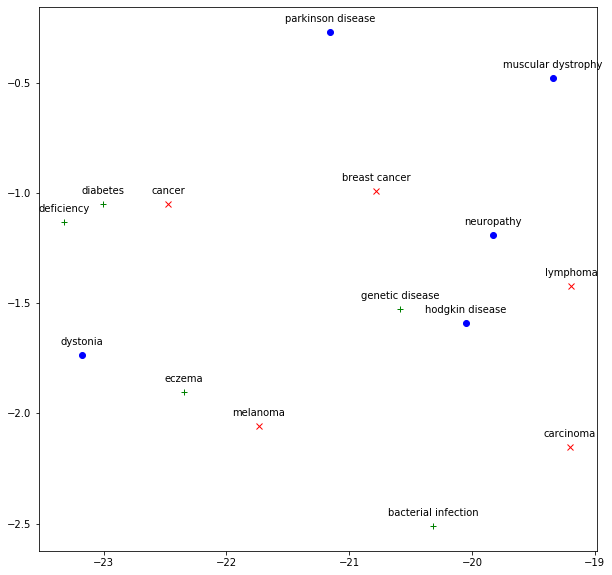

In [22]:
spectrum_activations = spectrum_embeddings_tensors[0][0][:,0,:].numpy()
tsne_spectrum = TSNE(n_components=2, perplexity=10, verbose=1, learning_rate=2,
                     random_state=123).fit_transform(spectrum_activations)

fig = plt.figure(figsize=(10,10))
plt.plot(tsne_spectrum[0:5, 0], tsne_spectrum[0:5, 1], 'rx')
plt.plot(tsne_spectrum[5:10, 0], tsne_spectrum[5:10, 1], 'bo')
plt.plot(tsne_spectrum[10:, 0], tsne_spectrum[10:, 1], 'g+')
for (x,y, label) in zip(tsne_spectrum[0:, 0], tsne_spectrum[0:, 1], spectrum_df.sentence.values.tolist() ):
    plt.annotate(label, # this is the text
                 (x,y), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center

# 3.4 Training
Now that the graphs are set up, the action can begin.  You'll train the model with the NeuralModuleFactory `.train()` function. We need to set how many epochs and GPUs we'll be using.

In [23]:
NUM_EPOCHS = 5
NUM_GPUS = 1

train_data_size = len(dl_train)
steps_per_epoch = math.ceil(train_data_size / (BATCH_SIZE * NUM_GPUS))

For training, we also need to set the learning rate, optimizer, and callbacks for logging.  

## 3.4.1 Set the Learning Rate and Optimizer
For this project, we'll set the learning rate to 0.00005 and use a learning rate function, `WarmupAnnealing`.  We'll also use the popular [`adam`](https://machinelearningmastery.com/adam-optimization-algorithm-for-deep-learning/) optimization algorithm.  These values can be changed later if you wish.  We can see a list of available learning rate policies with the `get_all_lr_classes()` function.

In [24]:
nemo.utils.lr_policies.get_all_lr_classes()

{'CosineAnnealing': nemo.utils.lr_policies.CosineAnnealing,
 'InverseSquareRootAnnealing': nemo.utils.lr_policies.InverseSquareRootAnnealing,
 'PolynomialDecayAnnealing': nemo.utils.lr_policies.PolynomialDecayAnnealing,
 'PolynomialHoldDecayAnnealing': nemo.utils.lr_policies.PolynomialHoldDecayAnnealing,
 'SquareAnnealing': nemo.utils.lr_policies.SquareAnnealing,
 'SquareRootAnnealing': nemo.utils.lr_policies.SquareRootAnnealing,
 'WarmupAnnealing': nemo.utils.lr_policies.WarmupAnnealing,
 'WarmupHoldPolicy': nemo.utils.lr_policies.WarmupHoldPolicy,
 'WarmupPolicy': nemo.utils.lr_policies.WarmupPolicy,
 '_LRPolicy': nemo.utils.lr_policies._LRPolicy}

In [25]:
OPTIMIZER = 'adam'
LEARNING_RATE = 5e-5
lr_policy_fn = get_lr_policy('WarmupAnnealing',
                             total_steps=NUM_EPOCHS * steps_per_epoch,
                             warmup_ratio=0.1)

## 3.4.2 Create the Callbacks
Callbacks are used to record and log metrics and save checkpoints for the training and evaluation. We use callbacks to print to screen and also to tensorboard.  Note that the eval_callback is where the validation set is tested against the trained network for each loop.

In [26]:
# Create callback for simple logging
train_callback = SimpleLogger(step_freq=steps_per_epoch)

# Create callback for tensorboard logging
tensorboard_callback = TensorboardLogger(nf.tb_writer,
                                        step_freq=steps_per_epoch)

# Create callback to evaluate each epoch against the validation data
eval_callback = EvaluatorCallback(eval_tensors=[val_logits, val_labels],
                                            user_iter_callback=lambda x, y: eval_iter_callback(x, y, dl_val),
                                            user_epochs_done_callback=lambda x:
                                                eval_epochs_done_callback(x, f'{nf.work_dir}graphs'),
                                            tb_writer=nf.tb_writer,
                                            eval_step=steps_per_epoch)

# Create callback to save checkpoints
ckpt_callback = CheckpointCallback(folder=nf.checkpoint_dir,
                                             epoch_freq=1)

## 3.4.3 Run the Trainer
It is not necessary to reset the trainer the first time, but the reset function is included here in case you want to change the number of epochs for more training. Reset is required in order to start the trainer again.  

In [27]:
nemo.core.NeuralModuleFactory.reset_trainer(nf)

Selected optimization level O1:  Insert automatic casts around Pytorch functions and Tensor methods.

Defaults for this optimization level are:
enabled                : True
opt_level              : O1
cast_model_type        : None
patch_torch_functions  : True
keep_batchnorm_fp32    : None
master_weights         : None
loss_scale             : dynamic
Processing user overrides (additional kwargs that are not None)...
After processing overrides, optimization options are:
enabled                : True
opt_level              : O1
cast_model_type        : None
patch_torch_functions  : True
keep_batchnorm_fp32    : None
master_weights         : None
loss_scale             : dynamic
[NeMo I 2020-07-21 16:00:35 callbacks:534] Found 2 modules with weights:
[NeMo I 2020-07-21 16:00:35 callbacks:536] SequenceClassifier
[NeMo I 2020-07-21 16:00:35 callbacks:536] BERT
[NeMo I 2020-07-21 16:00:35 callbacks:537] Total model parameters: 110075139
[NeMo I 2020-07-21 16:00:35 callbacks:473] Found chec

[NeMo W 2020-07-21 16:00:35 callbacks:499] For module BERT, no file matches  in /dli/task/data/logs-tc-bbu/checkpoints
[NeMo W 2020-07-21 16:00:35 callbacks:501] Checkpoint folder /dli/task/data/logs-tc-bbu/checkpoints was present but nothing was restored. Continuing training from random initialization.


[NeMo I 2020-07-21 16:00:36 callbacks:232] loss: 1.1053386
[NeMo I 2020-07-21 16:00:36 deprecated_callbacks:316] Doing Evaluation ..............................
[NeMo I 2020-07-21 16:00:36 text_classification_callback:57] Accuracy: 0.37
[NeMo I 2020-07-21 16:00:36 text_classification_callback:64] Sampled preds: [2 2 1 2 2 0 2 2 0 2 2 2 2 2 2 2 0 2 2 0]
[NeMo I 2020-07-21 16:00:36 text_classification_callback:65] Sampled labels: [2 0 0 2 1 0 1 0 1 1 2 2 1 2 1 2 2 2 1 0]
[NeMo I 2020-07-21 16:00:36 callback_utils:92] Confusion matrix:
    [[ 7  8 17]
     [ 3  2 19]
     [ 9  7 28]]
[NeMo I 2020-07-21 16:00:36 text_classification_callback:67]               precision    recall  f1-score   support
    
               0     0.3684    0.2188    0.2745        32
               1     0.1176    0.0833    0.0976        24
               2     0.4375    0.6364    0.5185        44
    
        accuracy                         0.3700       100
       macro avg     0.3079    0.3128    0.2969       1

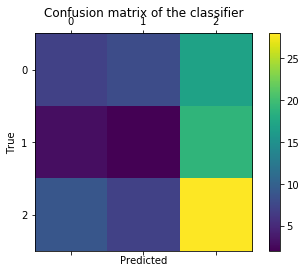

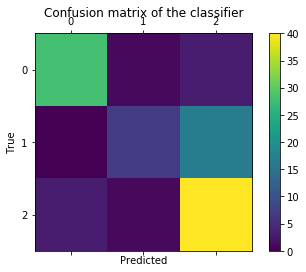

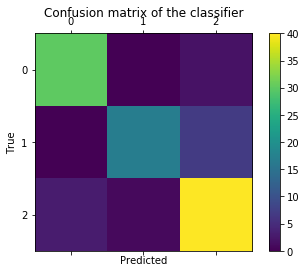

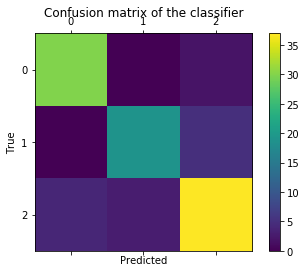

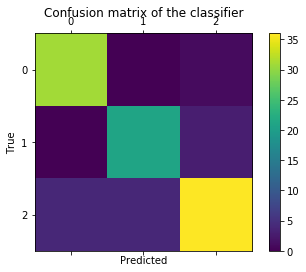

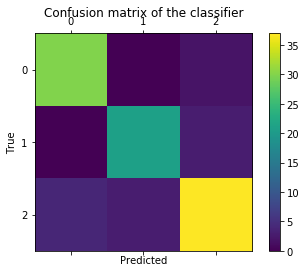

In [28]:
%%time
nf.train(tensors_to_optimize=[train_loss],
         callbacks=[train_callback, tensorboard_callback, eval_callback, ckpt_callback],
         lr_policy=lr_policy_fn,
         optimizer=OPTIMIZER,
         optimization_params={'num_epochs': NUM_EPOCHS, 'lr': LEARNING_RATE})

## 3.4.4 Visualize Embeddings After Training
Update the embeddings with the newly trained language model and run the inference again.  Then, show the t-SNE plot.

In [29]:
spectrum_embeddings = lm(input_ids=spectrum_input,
                           token_type_ids=spectrum_token_types,
                           attention_mask=spectrum_attn_mask)
spectrum_embeddings_tensors = nf.infer(tensors=[spectrum_embeddings])

[NeMo I 2020-07-21 16:01:02 actions:695] Evaluating batch 0 out of 1


[t-SNE] Computing 14 nearest neighbors...
[t-SNE] Indexed 15 samples in 0.000s...
[t-SNE] Computed neighbors for 15 samples in 0.002s...
[t-SNE] Computed conditional probabilities for sample 15 / 15
[t-SNE] Mean sigma: 3.639958
[t-SNE] KL divergence after 150 iterations with early exaggeration: 33.956806
[t-SNE] KL divergence after 600 iterations: 0.038487


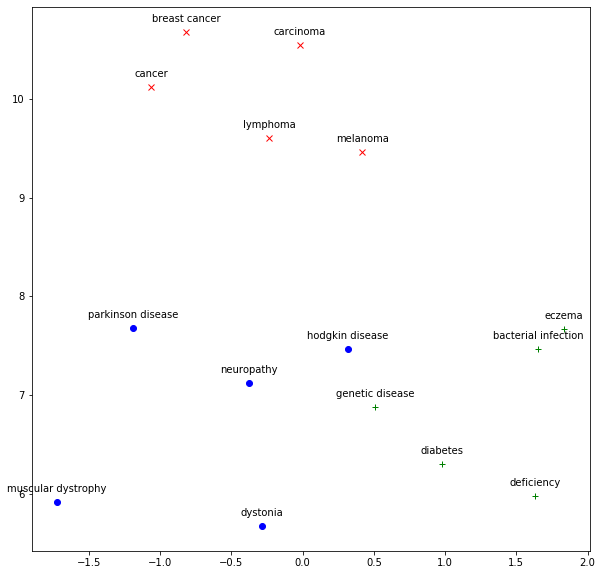

In [30]:
spectrum_activations = spectrum_embeddings_tensors[0][0][:,0,:].numpy()
tsne_spectrum = TSNE(n_components=2, perplexity=10, verbose=1, learning_rate=2,
                     random_state=123).fit_transform(spectrum_activations)

fig = plt.figure(figsize=(10,10))
plt.plot(tsne_spectrum[0:5, 0], tsne_spectrum[0:5, 1], 'rx')
plt.plot(tsne_spectrum[5:10, 0], tsne_spectrum[5:10, 1], 'bo')
plt.plot(tsne_spectrum[10:, 0], tsne_spectrum[10:, 1], 'g+')
for (x,y, label) in zip(tsne_spectrum[0:, 0], tsne_spectrum[0:, 1], spectrum_df.sentence.values.tolist() ):
    plt.annotate(label, # this is the text
                 (x,y), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center

# 3.5 Inference
Now that the language model and classifier are trained with new weights, you can set up the training graph. Then, you can run inference on the test data and look at the results.

## 3.5.1 Exercise: Create the Test Graph
The test graph is a little different than the training and validation graphs.  For inference, we don't have any labels to learn from, and there is no loss function.

<figure>
    <img src="../images/nemo/test_graph.png" width=600>
    <figcaption style="text-align:center;">Test Graph</figcaption>
</figure>

In the cell below, look for and fix the <i><strong><span style="color:green;">#FIXME</span><strong></i> code lines (there are three of them).  If you get stuck, look back at the training graph you just set up for inspiration or the [solution notebook](solution_notebooks/SOLN_030_TextClassification.ipynb) for the answer.

In [31]:
# Define the data output from the data layer
test_input, test_token_types, test_attn_mask, _ = dl_test()

# Define test_embeddings from the language model, based on inputs from the data layer  
test_embeddings = lm(input_ids=test_input,
                      token_type_ids=test_token_types,
                      attention_mask=test_attn_mask)

# Define test_logits from the clasifier based on the language model embeddings
test_logits = mlp(hidden_states=test_embeddings)

Great!  Now you can run inference with the test set!  

## 3.5.2 Run Inference on the Test Set

In [32]:
%%time
test_logits_tensors = nf.infer(tensors=[test_logits])

[NeMo I 2020-07-21 16:01:03 actions:695] Evaluating batch 0 out of 1
CPU times: user 46.5 ms, sys: 319 ms, total: 365 ms
Wall time: 358 ms


Gather the probabilities produced for each of the three labels on each test abstract. 

In [33]:
test_probs = [torch.nn.functional.softmax(torch.cat(test_logits_tensors[0]), dim=1).numpy()[:, label_index] for label_index in range(3)]

In [34]:
test_df = pd.read_csv(os.path.join(DATA_DIR, 'labeled_test.tsv'), sep='\t')

In [35]:
# test_df['prob'] = test_probs 
test_df['prob0'] = test_probs[0] 
test_df['prob1'] = test_probs[1]
test_df['prob2'] = test_probs[2]
inference_file = os.path.join(DATA_DIR, 'test_inference.tsv')
test_df.to_csv(inference_file, sep='\t', index=False)

For convenience, we'll create a function to use in a loop to output the results.

In [36]:
def sample_classification(sample):
    sentence = sample.sentence
    prob0 = sample.prob0.values[0]
    prob1 = sample.prob1.values[0]
    prob2 = sample.prob2.values[0]
    result = f'{sentence} \n cancer | neurological | other\n {prob0} | {prob1} | {prob2}'
    return result

## 3.5.3 Inference Results

In [37]:
df = pd.read_csv(inference_file, sep='\t')
for ind in range(len(df)):
    sample = df[ind:ind+1]
    print(sample_classification(sample))

0    Clustering of missense mutations in the ataxia-telangiectasia gene in a sporadic T-cell leukaemia. Ataxia-telangiectasia ( A-T ) is a recessive multi-system disorder caused by mutations in the ATM gene at 11q22-q23 ( ref . 3 ) . The risk of cancer , especially lymphoid neoplasias , is substantially elevated in A-T patients and has long been associated with chromosomal instability . By analysing tumour DNA from patients with sporadic T-cell prolymphocytic leukaemia ( T-PLL ) , a rare clonal malignancy with similarities to a mature T-cell leukaemia seen in A-T , we demonstrate a high frequency of ATM mutations in T-PLL . In marked contrast to the ATM mutation pattern in A-T , the most frequent nucleotide changes in this leukaemia were missense mutations . These clustered in the region corresponding to the kinase domain , which is highly conserved in ATM-related proteins in mouse , yeast and Drosophila . The resulting amino-acid substitutions are predicted to interfere with ATP bindi

Typical results should looks something like:

## 3.5.4 Single Sentence Classification

In [38]:
def classify_sentence(nf, tokenizer, bert, mlp, sentence):
    sentence = sentence.lower()
    tmp_file = "/tmp/tmp_sentence.tsv"
    with open(tmp_file, 'w+') as tmp_tsv:
        header = 'sentence\tlabel\n'
        line = sentence + '\t0\n'
        tmp_tsv.writelines([header, line])

    tmp_data = BertTextClassificationDataLayer(input_file=tmp_file,
                                               tokenizer=tokenizer,
                                               max_seq_length=128,
                                               batch_size=1)
    
    tmp_input, tmp_token_types, tmp_attn_mask, _ = tmp_data()
    tmp_embeddings = bert(input_ids=tmp_input,
                          token_type_ids=tmp_token_types,
                          attention_mask=tmp_attn_mask)
    tmp_logits = mlp(hidden_states=tmp_embeddings)
    tmp_logits_tensors = nf.infer(tensors=[tmp_logits, tmp_embeddings])
    tmp_probs0 = torch.nn.functional.softmax(torch.cat(tmp_logits_tensors[0])).numpy()[:, 0]
    tmp_probs1 = torch.nn.functional.softmax(torch.cat(tmp_logits_tensors[0])).numpy()[:, 1]
    tmp_probs2 = torch.nn.functional.softmax(torch.cat(tmp_logits_tensors[0])).numpy()[:, 2]
    print(f'\n******\n{sentence} \n {tmp_probs0[0]} | {tmp_probs1[0]} | {tmp_probs2[0]}\n********\n')

In [41]:
sentences = ['In contrast , no mutations were detected in the p53 gene , suggesting that this tumour suppressor is not frequently altered in this leukaemia .',
             'The first predictive testing for Huntington disease ( HD ) was based on analysis of linked polymorphic DNA markers to estimate the likelihood of inheriting the mutation for HD .',
             'Germ-line mutations of the BRCA1 gene predispose women to early-onset breast and ovarian cancer by compromising the genes presumptive function as a tumor suppressor .',
             'Further studies suggested that low dilutions of C5D serum contain a factor ( or factors ) interfering at some step in the hemolytic assay of C5 , rather than a true C5 inhibitor or inactivator .'
            ]
# should be 0, 1, 0, 2 
for sentence in sentences:
    classify_sentence(nf, tokenizer, lm, mlp, sentence)

[NeMo I 2020-07-21 16:07:29 text_classification_dataset:82] /tmp/tmp_sentence.tsv: 1
[NeMo I 2020-07-21 16:07:29 data_preprocessing:250] Min: 32 |                  Max: 32 |                  Mean: 32.0 |                  Median: 32.0
[NeMo I 2020-07-21 16:07:29 data_preprocessing:252] 75 percentile: 32.0
[NeMo I 2020-07-21 16:07:29 data_preprocessing:253] 99 percentile: 32.0
[NeMo I 2020-07-21 16:07:29 text_classification_dataset:118] 0 out of 1                         sentences with more than 128 subtokens.
[NeMo I 2020-07-21 16:07:29 text_classification_dataset:175] *** Example ***
[NeMo I 2020-07-21 16:07:29 text_classification_dataset:176] example_index: 0
[NeMo I 2020-07-21 16:07:29 text_classification_dataset:177] subtokens: [CLS] in contrast , no mutations were detected in the p ##53 gene , suggesting that this tu ##mour suppress ##or is not frequently altered in this le ##uka ##emia . [SEP]
[NeMo I 2020-07-21 16:07:29 text_classification_dataset:178] sent_label: 0
[NeMo I 2020-

# 3.6 Exercise: Change the Language Model
Now that you've built the project, you can experiment with different settings, especially different language models.  For this exercise, try 'bert-large-uncased' or 'megatron-uncased'.  To do that, you'll need to restart the kernel to clear memory, and change the parameters in the [3.1.1 Input Parameters](3.1.1-Input-Parameters) section.  With these larger models, you'll need to reduce the batch size to avoid an out-of-memory error.

<h2 style="color:green;">Congratulations!</h2>

You've built a text classifier with three classes and mastered creating graphs for training, validation, and test with NeMo.  You experimented with alternate language models and tested the result.  You're ready to try a different NLP task.<br>

Move on to [4.0 Build a Named-Entity Recognizer](040_NamedEntityRecognition.ipynb).

<a href="https://www.nvidia.com/dli"> <img src="../images/DLI_Header.png" alt="Header" style="width: 400px;"/> </a>